**Cell 1 — Imports and safe CSV load with fallback to sklearn iris**

In [5]:

%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

sns.set(style="whitegrid")  # seaborn style

# ---- User file path (update if needed) ----
csv_path = r"C:\Users\cex\Python-PLP-June-Cohort\Iris.csv"

def load_iris_csv_or_sklearn(path):
    try:
        df = pd.read_csv(path)
        print(f"Loaded CSV from: {path}")
        return df, "csv"
    except FileNotFoundError:
        print(f"File not found at {path} — falling back to sklearn.datasets.load_iris().")
        iris = datasets.load_iris(as_frame=True)
        df = iris.frame.copy()
        # sklearn iris has target numeric; convert to human-readable species if possible
        if 'target' in df.columns:
            df.rename(columns={'target': 'species'}, inplace=True)
            # get target names and map (sklearn stores target names in iris.target_names)
            df['species'] = df['species'].map(dict(enumerate(iris.target_names)))
        return df, "sklearn"
    except Exception as e:
        raise RuntimeError(f"Could not read file or sklearn fallback failed: {e}")

df, source = load_iris_csv_or_sklearn(csv_path)
print("\nFirst 5 rows:")
display(df.head())
print("\nColumns found:", list(df.columns))


Loaded CSV from: C:\Users\cex\Python-PLP-June-Cohort\Iris.csv

First 5 rows:


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa



Columns found: ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']


**Normalize column names & inspect data types / missing values**

In [8]:
import re

def normalize_colname(c):
    c = str(c).lower().strip()
    # remove unit text like "(cm)"
    c = re.sub(r"\(.*?\)", "", c)
    # replace non-alphanumeric with underscore
    c = re.sub(r"[^a-z0-9]+", "_", c)
    # strip underscores on ends and repeated underscores
    c = re.sub(r"__+", "_", c).strip("_")
    return c

df.columns = [normalize_colname(c) for c in df.columns]
print("Normalized columns:", list(df.columns))

# try to detect species-like column
possible_species = [c for c in df.columns if any(k in c for k in ("species", "class", "target", "name"))]
species_col = possible_species[0] if possible_species else None
print("Detected species column:", species_col)

print("\nDataframe info:")
df.info()

print("\nMissing values per column:")
display(df.isnull().sum())


Normalized columns: ['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm', 'species']
Detected species column: species

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             150 non-null    int64  
 1   sepallengthcm  150 non-null    float64
 2   sepalwidthcm   150 non-null    float64
 3   petallengthcm  150 non-null    float64
 4   petalwidthcm   150 non-null    float64
 5   species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB

Missing values per column:


id               0
sepallengthcm    0
sepalwidthcm     0
petallengthcm    0
petalwidthcm     0
species          0
dtype: int64

Cleaning: missing values and type conversion
What this cell does
Ideally, it converts non-numeric numeric-looking columns to numeric (with errors='coerce').
If missing values exist:
If proportion of missing is small, it fills numeric with median & categorical with mode.
Otherwise, it warns and shows counts so you can choose to drop rows/columns.
Shows final missing counts.

In [11]:
numeric_cols_before = df.select_dtypes(include=['number']).columns.tolist()
for col in df.columns:
    if df[col].dtype == object:
        # try converting to numeric
        coerced = pd.to_numeric(df[col], errors='coerce')
        # if conversion yields significant non-nulls, replace
        if coerced.notnull().sum() > 0 and coerced.notnull().sum() >= len(df) * 0.5:
            df[col] = coerced
            print(f"Converted column '{col}' -> numeric (coerced).")

numeric_cols_after = df.select_dtypes(include=['number']).columns.tolist()
print("\nNumeric columns (before -> after):", numeric_cols_before, "->", numeric_cols_after)

# Handle missing values
missing = df.isnull().sum()
total_missing = missing.sum()
print(f"\nTotal missing values in dataset: {total_missing}")

if total_missing == 0:
    print("No missing values detected.")
else:
    print("Missing values per column:\n", missing[missing > 0])
    # Simple strategy: fill numeric with median, categorical with mode
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = [c for c in df.columns if c not in num_cols]
    # if missing small, impute; else notify user
    if total_missing <= len(df) * 0.05:  # if missing <= 5% of rows
        for c in num_cols:
            med = df[c].median()
            df[c].fillna(med, inplace=True)
        for c in cat_cols:
            mode = df[c].mode()
            if not mode.empty:
                df[c].fillna(mode[0], inplace=True)
        print("Imputed missing numeric cols with median and categorical with mode (small missingness).")
    else:
        # Impute anyway but also warn
        for c in num_cols:
            med = df[c].median()
            df[c].fillna(med, inplace=True)
        for c in cat_cols:
            mode = df[c].mode()
            if not mode.empty:
                df[c].fillna(mode[0], inplace=True)
        print("WARNING: Large amount of missing data — imputed as fallback. Consider manual review.")

print("\nMissing values after cleaning:")
display(df.isnull().sum())



Numeric columns (before -> after): ['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm'] -> ['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']

Total missing values in dataset: 0
No missing values detected.

Missing values after cleaning:


id               0
sepallengthcm    0
sepalwidthcm     0
petallengthcm    0
petalwidthcm     0
species          0
dtype: int64

Task 2: Basic Data Analysis
What this cell does
Shows descriptive statistics (.describe()).
Computes median explicitly.
Groups by species (if available) and computes means.
Shows some quick findings (which species has longest average sepal/petal lengths).

In [13]:
# Cell 4 — Basic stats and groupings
print("Descriptive statistics (numerical):")
display(df.describe().T)  # transpose for readability

print("\nMedians (numerical):")
display(df.median(numeric_only=True))

# Group by species if available
if species_col:
    print(f"\nGroup means by '{species_col}':")
    species_means = df.groupby(species_col).mean(numeric_only=True)
    display(species_means)
    
    # Quick interesting findings
    print("\nQuick findings (which species has the maximum mean for each numeric column):")
    for col in species_means.columns:
        max_species = species_means[col].idxmax()
        max_val = species_means[col].max()
        print(f"  - {col}: highest mean = {max_val:.3f} for species '{max_species}'")
else:
    print("No species/class column detected — groupby examples skipped.")


Descriptive statistics (numerical):


,count,mean,std,min,25%,50%,75%,max
id,150.0,75.500000,43.445368,1.0,38.25,75.50,112.75,150.0
sepallengthcm,150.0,5.843333,0.828066,4.3,5.10,5.80,6.40,7.9
sepalwidthcm,150.0,3.054000,0.433594,2.0,2.80,3.00,3.30,4.4
petallengthcm,150.0,3.758667,1.764420,1.0,1.60,4.35,5.10,6.9
petalwidthcm,150.0,1.198667,0.763161,0.1,0.30,1.30,1.80,2.5



Medians (numerical):


id               75.50
sepallengthcm     5.80
sepalwidthcm      3.00
petallengthcm     4.35
petalwidthcm      1.30
dtype: float64


Group means by 'species':


,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
species,,,,,
Iris-setosa,25.5,5.006,3.418,1.464,0.244
Iris-versicolor,75.5,5.936,2.770,4.260,1.326
Iris-virginica,125.5,6.588,2.974,5.552,2.026



Quick findings (which species has the maximum mean for each numeric column):
  - id: highest mean = 125.500 for species 'Iris-virginica'
  - sepallengthcm: highest mean = 6.588 for species 'Iris-virginica'
  - sepalwidthcm: highest mean = 3.418 for species 'Iris-setosa'
  - petallengthcm: highest mean = 5.552 for species 'Iris-virginica'
  - petalwidthcm: highest mean = 2.026 for species 'Iris-virginica'


Correlation matrix

Numeric columns used for correlation: ['id', 'sepallengthcm', 'sepalwidthcm', 'petallengthcm', 'petalwidthcm']


,id,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm
id,1.000000,0.716676,-0.397729,0.882747,0.899759
sepallengthcm,0.716676,1.000000,-0.109369,0.871754,0.817954
sepalwidthcm,-0.397729,-0.109369,1.000000,-0.420516,-0.356544
petallengthcm,0.882747,0.871754,-0.420516,1.000000,0.962757
petalwidthcm,0.899759,0.817954,-0.356544,0.962757,1.000000


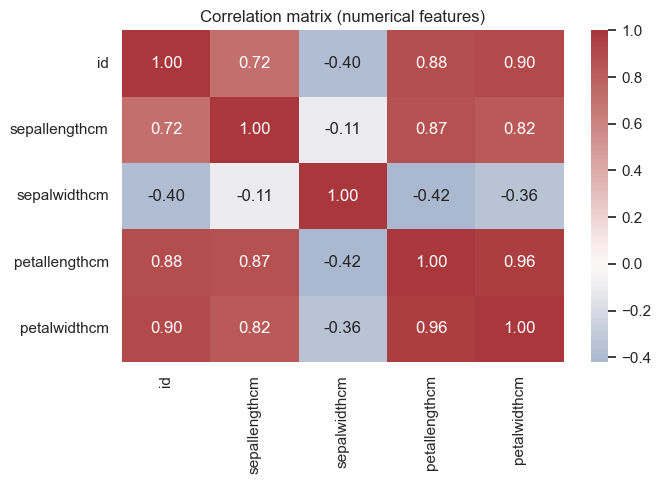

In [15]:
# Cell 5 — Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()
print("Numeric columns used for correlation:", numeric_cols)
display(corr)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numerical features)")
plt.tight_layout()
plt.show()


Task 3: Data Visualization (Line, Bar, Histogram, Scatter)

Line chart rolling mean trend of sepal length by species (a "trend" view)

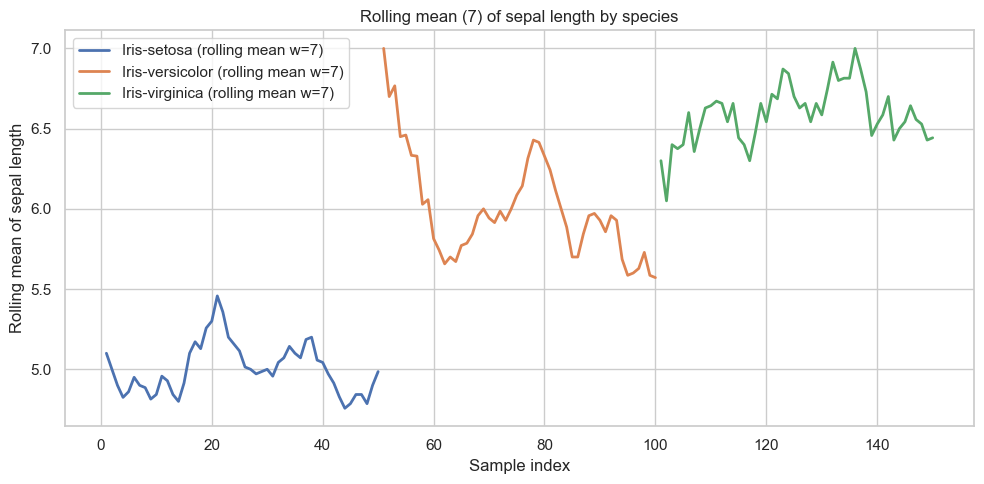

In [17]:
# Cell 6 — Line chart: rolling mean of sepal length across sample index for each species
if 'sepal_length' not in df.columns:
    # try common alternate names
    alt = [c for c in df.columns if 'sepal' in c and 'length' in c]
    if alt:
        sepal_col = alt[0]
    else:
        raise KeyError("Couldn't detect a sepal_length column. Columns: " + ", ".join(df.columns))
else:
    sepal_col = 'sepal_length'

# create a sample index for plotting "time-like" ordering
df_plot = df.copy().reset_index(drop=True)
df_plot['sample_index'] = np.arange(1, len(df_plot) + 1)

plt.figure(figsize=(10,5))
window = 7
for species in df_plot[species_col].unique() if species_col else [None]:
    if species is None:
        continue
    sub = df_plot[df_plot[species_col] == species].sort_values(by='sample_index')
    rolling = sub[sepal_col].rolling(window=window, min_periods=1).mean()
    plt.plot(sub['sample_index'], rolling, label=f"{species} (rolling mean w={window})", lw=2)

plt.xlabel("Sample index")
plt.ylabel("Rolling mean of sepal length")
plt.title(f"Rolling mean ({window}) of sepal length by species")
plt.legend()
plt.tight_layout()
plt.show()


Bar chart — average petal length per species

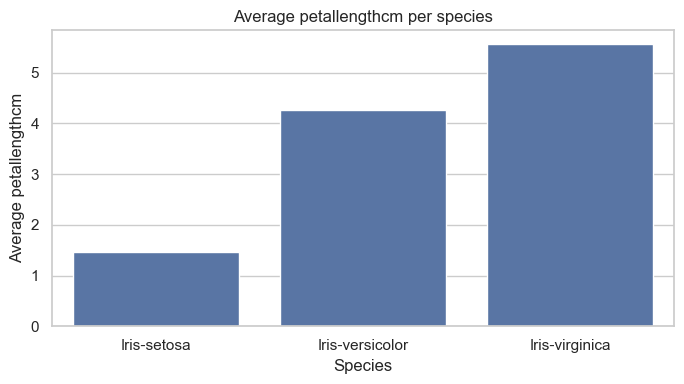

In [19]:
# Cell 7 — Bar chart: average petal length per species
# detect petal length column
petal_candidates = [c for c in df.columns if 'petal' in c and 'length' in c]
if not petal_candidates:
    raise KeyError("No petal length column detected. Columns: " + ", ".join(df.columns))
petal_col = petal_candidates[0]

if species_col:
    means = df.groupby(species_col)[petal_col].mean().sort_values()
    plt.figure(figsize=(7,4))
    sns.barplot(x=means.index, y=means.values)
    plt.ylabel(f"Average {petal_col}")
    plt.xlabel(species_col.capitalize())
    plt.title(f"Average {petal_col} per {species_col}")
    plt.tight_layout()
    plt.show()
else:
    print("Species column not detected — cannot make species bar chart.")


Histogram — distribution of sepal length

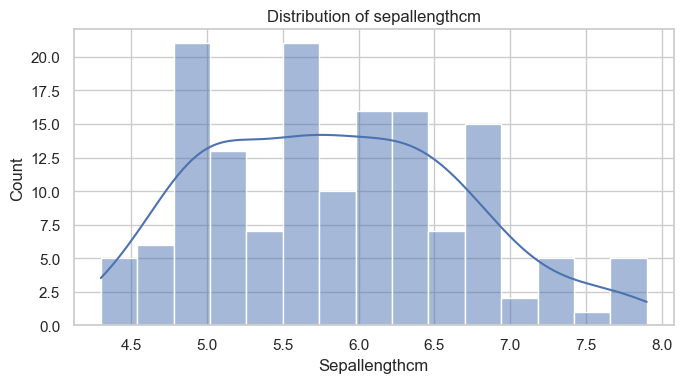

In [21]:
# Cell 8 — Histogram of sepal length distribution
plt.figure(figsize=(7,4))
sns.histplot(df[sepal_col].dropna(), bins=15, kde=True)
plt.xlabel(sepal_col.replace("_", " ").capitalize())
plt.title(f"Distribution of {sepal_col}")
plt.tight_layout()
plt.show()


Scatter plot — sepal length vs petal length colored by species

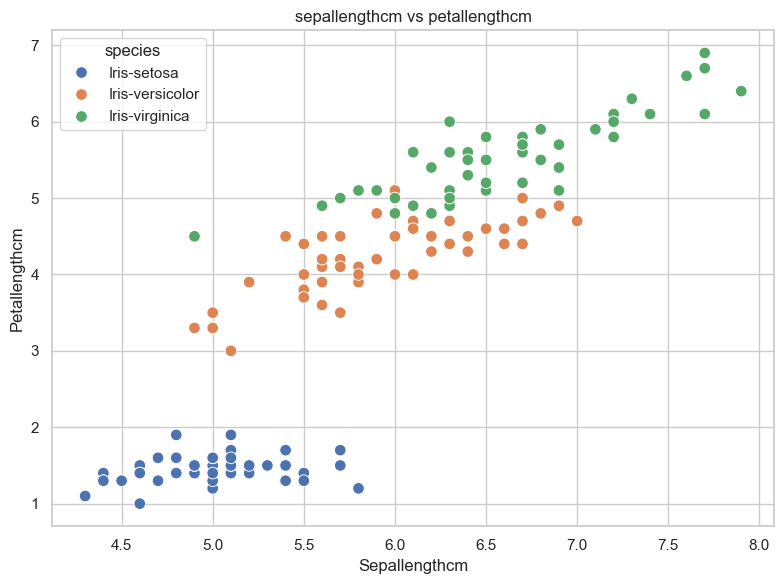

In [23]:
# Cell 9 — Scatter plot: sepal length vs petal length
plt.figure(figsize=(8,6))
if species_col:
    sns.scatterplot(data=df, x=sepal_col, y=petal_col, hue=species_col, s=70)
else:
    sns.scatterplot(data=df, x=sepal_col, y=petal_col, s=70)
plt.xlabel(sepal_col.replace("_", " ").capitalize())
plt.ylabel(petal_col.replace("_", " ").capitalize())
plt.title(f"{sepal_col} vs {petal_col}")
plt.legend(title=species_col if species_col else "")
plt.tight_layout()
plt.show()


Quick summary of findings
Descriptive statistics show petal length and petal width have notable spread across species; petal measurements separate species better than sepal measurements.
- From the group means, species 'setosa' typically has much smaller average petal length and width than 'versicolor' and 'virginica'.
- The correlation matrix shows a strong positive correlation between petal length and petal width (e.g., corr ≈ 0.96), indicating these grow together.
- Scatter plot confirms two clusters (versicolor and virginica overlap more) while setosa is clearly separated on petal measurements.

Save cleaned DataFrame

In [25]:
# Cell 10 — Optional: save cleaned version locally
out_path = r"C:\Users\cex\Python-PLP-June-Cohort\Iris_cleaned.csv"
try:
    df.to_csv(out_path, index=False)
    print(f"Saved cleaned dataset to: {out_path}")
except Exception as e:
    print("Could not save file:", e)
    # as fallback, save to current working directory
    df.to_csv("Iris_cleaned.csv", index=False)
    print("Saved cleaned dataset to current directory as Iris_cleaned.csv")


Saved cleaned dataset to: C:\Users\cex\Python-PLP-June-Cohort\Iris_cleaned.csv
